## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
#!pip install nlp
#!pip install datasets

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#import nlp
import random
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


# Assuming the actual classes are 'negative', 'positive', and 'neutral'
classes = ['negative', 'positive', 'neutral']

# Modify the show_confusion_matrix function to use the correct number of ticks:
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(len(classes))), labels=classes) # Use len(classes) for ticks
    plt.yticks(list(range(len(classes))), labels=classes) # Use len(classes) for ticks
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
data = pd.read_csv('feedback.tsv', sep='\t', index_col=0, encoding='latin-1')
data.head()

<ipython-input-3-fb3dfdf53286>:1: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('feedback.tsv', sep='\t', index_col=0, encoding='latin-1')


,StudentComments,Rating,totalwords,Sentiment,sent_pretrained,subjectivity,subj-score,isSame
0,good,4.96,1,positive,positive,subjective,0.6,TRUE
1,good,5.00,1,positive,positive,subjective,0.6,TRUE
2,teacher,4.25,1,positive,neutral,objective,0.0,fake
3,friendly teacher but not enough ability to enc...,4.38,10,positive,neutral,subjective,0.5,fake
4,teacher,4.92,1,positive,neutral,objective,0.0,fake


In [ ]:
data_classify = data[['StudentComments', 'Sentiment']]
data_classify.head()

,StudentComments,Sentiment
0,good,positive
1,good,positive
2,teacher,positive
3,friendly teacher but not enough ability to enc...,positive
4,teacher,positive


In [ ]:
data_classify.shape

(1048575, 2)

In [ ]:
data_classify.drop_duplicates(inplace=True)
data_classify.shape

<ipython-input-6-85c275306486>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_classify.drop_duplicates(inplace=True)


(226457, 2)

In [ ]:
data_classify.isna().sum()

,0
StudentComments,0
Sentiment,0


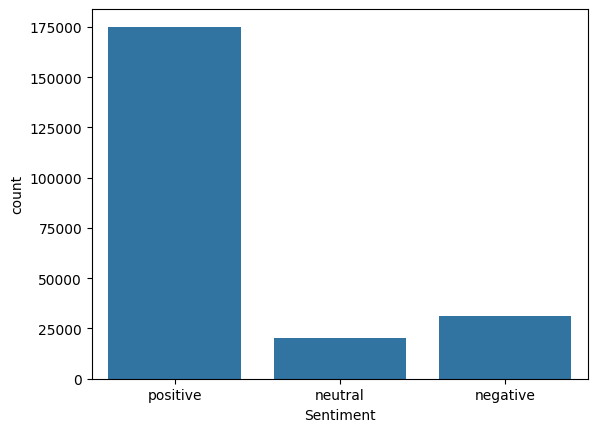

In [ ]:
sns.countplot(x='Sentiment', data=data_classify)
plt.show()

In [ ]:
# Chia dữ liệu thành tập train và tập tạm thời (temp)
train_data, temp_data = train_test_split(data_classify, test_size=0.2, random_state=42)

# Chia temp thành tập validation và test
val_data, test_data = train_test_split(data_classify, test_size=0.5, random_state=42)


In [ ]:
def get_comments(df):
  data = df.values.tolist()
  comments = []
  labels = []

  for i in range(len(data)):
    comments.append(data[i][0])
    labels.append(data[i][1])
  return comments, labels

In [ ]:
train_comments, train_labels = get_comments(train_data)
val_comments, val_labels = get_comments(val_data)
test_comments, test_labels = get_comments(test_data)

In [ ]:
for i in range(5):
  print(f"('{train_comments[i]}', '{train_labels[i]}')")

('sir onek valo .', 'positive')
('good teacher & her english is so good.', 'positive')
('she is fine. (not like what we've heard from others in the past!!!) if she could practice a little bengali in giving lectures (25-30% only) that will be excellent! coz, not all of us from o/a'level background. as a result sometimes, we lose our concentration, can't catch her lectures. except this, she is a good teacher!', 'positive')
('she is a very nice and friendly teacher. really a good teacher.', 'positive')
('best teaching system i've ever seen.', 'positive')


## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_comments)

In [ ]:
print(train_comments[4])
tokenizer.texts_to_sequences([train_comments[4]])

best teaching system i've ever seen.


[[22, 16, 118, 343, 84, 108]]

In [ ]:
import pickle # Import the pickle module

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

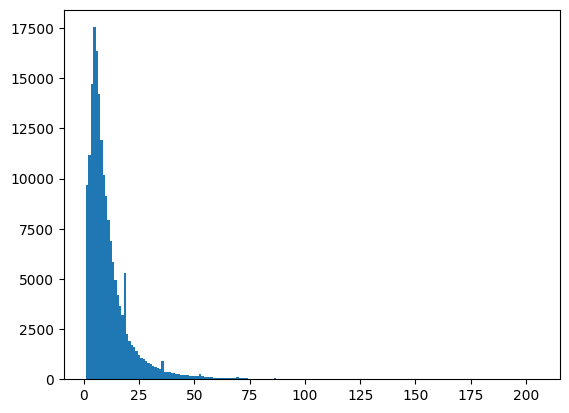

In [ ]:
length = [len(t.split(" ")) for t in train_comments]
plt.hist(length, bins=len(set(length)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 80

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=max_length)
  return padded

In [ ]:
padded_train_sequences = get_sequences(tokenizer, train_comments)

In [ ]:
padded_train_sequences.shape

(181165, 80)

In [ ]:
padded_train_sequences[4]

array([ 22,  16, 118, 343,  84, 108,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [ ]:
# convert to float32
padded_train_sequences = np.array(padded_train_sequences, dtype=np.float32)

In [ ]:
padded_train_sequences[4]

array([ 22.,  16., 118., 343.,  84., 108.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.], dtype=float32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(train_labels)
print(classes)

{'negative', 'positive', 'neutral'}


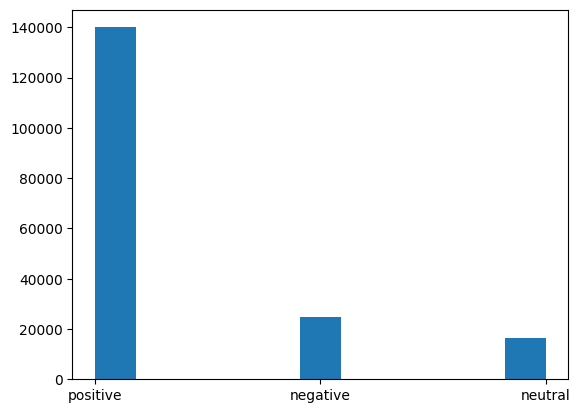

In [ ]:
plt.hist(train_labels, bins=11)
plt.show()

In [ ]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [ ]:
ids_to_classes = dict((v, k) for k, v in classes.items())
ids_to_classes

AttributeError: 'set' object has no attribute 'items'

In [ ]:
ids_to_names = lambda labels: [ids_to_classes[label] for label in labels]

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_comments, val_labels = get_comments(val_data)
val_sequences = get_sequences(tokenizer, val_comments)

In [ ]:
val_comments[0], val_labels[0]

('his strategy is very bad. his grading system is very bad. he gives grade as his wish.',
 'negative')

In [ ]:
val_labels = [class_to_index[label] for label in val_labels]

In [ ]:
val_sequences = np.array(val_sequences, dtype=np.float32)
val_labels = np.array(val_labels, dtype=np.float32)

In [ ]:
train_labels = [class_to_index[label] for label in train_labels]
train_labels = np.array(train_labels, dtype=np.float32)

In [ ]:
hypothesis = model.fit(
    x=padded_train_sequences,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 140s 24ms/step - accuracy: 0.7991 - loss: 0.5707 - val_accuracy: 0.8238 - val_loss: 0.4788
Epoch 2/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 121s 20ms/step - accuracy: 0.8266 - loss: 0.4747 - val_accuracy: 0.8312 - val_loss: 0.4627
Epoch 3/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 144s 21ms/step - accuracy: 0.8329 - loss: 0.4594 - val_accuracy: 0.8385 - val_loss: 0.4441
Epoch 4/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.8356 - loss: 0.4497 - val_accuracy: 0.8422 - val_loss: 0.4316
Epoch 5/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.8401 - loss: 0.4365 - val_accuracy: 0.8418 - val_loss: 0.4272
Epoch 6/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.8421 - loss: 0.4273 - val_accuracy: 0.8469 - val_loss: 0.4124
Epoch 7/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.8447 - loss: 0.4200 - val_accuracy: 0.8495 - val_loss: 0.4051
Epoch 8/20
5662/5662 ━━━━━━━━━━━━━━━━━━━━ 115s 20ms/step - accuracy: 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

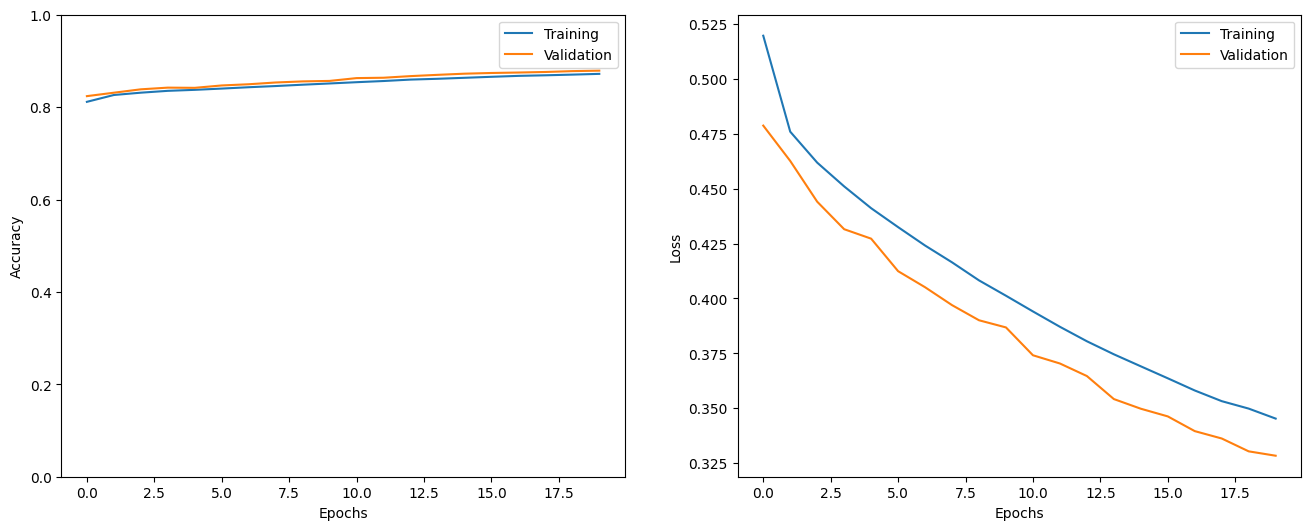

In [ ]:
show_history(hypothesis)

In [ ]:
test_comments, test_labels = get_comments(test_data)
test_sequences = get_sequences(tokenizer, test_comments)
#test_labels = names_to_ids(test_labels)
test_labels = [class_to_index[label] for label in test_labels]
test_labels = np.array(test_labels, dtype=np.float32)
test_sequences = np.array(test_sequences, dtype=np.float32)

In [ ]:
_ = model.evaluate(test_sequences, test_labels)

3539/3539 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.8198 - loss: 0.5839


In [ ]:
i = random.randint(0, len(test_labels)-1)

print(f'Tweet : {test_comments[i]}')
print(f'Emotion : {index_to_class[test_labels[i]]}')

i_prediction = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {test_comments[i]}')
print(f'Predicted Emotion : {predicted_class}')

Tweet : respect him a lot. i learned many things from him. he knows how to create interests on the subjects.
Emotion : positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

Tweet : respect him a lot. i learned many things from him. he knows how to create interests on the subjects.
Predicted Emotion : positive


In [ ]:
preds = model.predict(test_sequences)
pred_classes = np.argmax(preds, axis=1)

3539/3539 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step


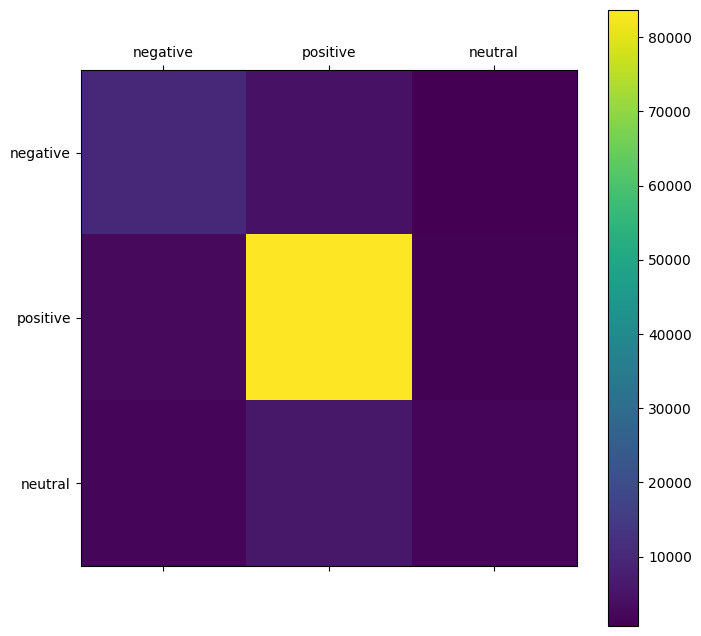

In [ ]:
# Now you can call the function:
show_confusion_matrix(test_labels, preds.argmax(axis=1), classes)

# Saving and Loading model

In [ ]:
model.save('model.h5')

In [ ]:
def get_sequences(tokenizer, tweets):
  max_length = 80
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=max_length)
  padded  = np.array(padded, dtype=np.float32)
  return padded

In [ ]:
classes = {'negative': 0, 'positive': 1, 'neutral': 2}
# Define ids_to_classes using index_to_class
ids_to_classes = {v: k for k, v in classes.items()} #Create the mapping of id to class name
# ids_to_names now uses the correctly defined ids_to_classes
ids_to_names = lambda labels: [ids_to_classes[label] for label in labels]
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
model = tf.keras.models.load_model('model.h5')
text = "not my favorite"
text_sequences = get_sequences(tokenizer, [text])
prediction = model.predict(text_sequences)
print(ids_to_names(prediction.argmax(axis=1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
['negative']
